# Advance Machine Learning

## PUBG Finish Placement Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO


# Attributes
* assists: Number of enemy players this player damaged that were killed by teammates.
* boosts: Number of boost items used.
* damageDealt: Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs: Number of enemy players knocked.
* headshotKills: Number of enemy players killed with headshots.
* heals: Number of healing items used.
* killPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player.
* kills: Number of enemy players killed. 
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death.
* matchDuration: Duration of match in seconds.
* matchType: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches. 
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. 
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. 

# Libraries

In [39]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import collections

import statistics 

import numpy as np

from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

import keras 
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Function

In [95]:
def load_data():
    fields = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 
              'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
               'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
    data = pd.read_csv('../data/dataset.csv', usecols=fields)
    # data = data['matchType' == 'squad-fpp']
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def select_typology(data, typology):
    
    if typology == 'solo-fpp':
        del data['DBNOs']
        del data['revives']
        
        
    data = data[data.matchType == typology]
    del data['matchType']
    print("SELECT TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    
    return data

def transform_task(data):
    labels = list()
    scores = data.winPlacePerc
    for score in scores:
        score = round(score, 2)
        if score >= 0 and score <= 0.2:
            labels.append(0)
        elif score >= 0.21 and score <= 0.4:
            labels.append(1)
        elif score >= 0.41 and score <= 0.6:
            labels.append(2)
        elif score >= 0.61 and score <= 0.8:
            labels.append(3)
        elif score >= 0.81 and score <= 1:
            labels.append(4)
        else:
            print("PROBLEMS VALUES: ", score)
            labels.append(-1)
    
    del data['winPlacePerc']
    
    data['label'] = labels
    
    data = data.drop(data[data.label == -1].index)
    
    print("CHANGE TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data


def preprocessing_data(dataset):
    
    data = dataset.values.copy()
    
    x = data[:, 0:-1].astype(np.float32) 
    y = data[:, -1]
    y = np_utils.to_categorical(y, 5)
    
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    
    return x, y

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["label"].value_counts()
    number = dict(collections.OrderedDict(sorted(number.items())))
    show = list()
    print(number)
    for value in number:
        show.append(number[value])
    print(show)
    ax1.pie(show, explode = (0, 0, 0, 0, 0.2), labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def print_kills_number(kills):
    
    plt.figure(figsize=(15,10))
    
    plt.title("Kills")
    plt.xlabel("# kills")
    plt.ylabel("times")
    
    kills_number = [0]*10
    names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
    
    for kill in kills:
        if kill >= 10:
            kills_number[9] += 1
        else:
            kills_number[kill] += 1
            
    print(kills_number)
    plt.bar(np.arange(10), height = kills_number)
    plt.show()

def print_sns_hist(value, name):
    plt.figure(figsize=(15, 10))
    value.name = name
    sns.distplot(value)
    
def print_sns_join_plot(x_value, y_value, dataset):
    sns.jointplot(x_value, y_value, dataset, ratio=3, height=15)
    plt.show()

def print_sns_pairplot(dataset, based):
    plt.figure(figsize=(60, 60))
    sns.set(font_scale=5)
    g = sns.pairplot(dataset, vars=["killPlace", "weaponsAcquired", "kills", "damageDealt", "walkDistance"],
                     hue="label", markers=["o", "x"], height = 10)
    new_labels = ['Low', 'High']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    plt.show()
    sns.set()
    
def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)
    
def define_net(first_layer, second_layer, opt, input_size):
    model = Sequential()
    model.add(Dense(first_layer, input_shape = (input_size,), activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(second_layer, activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])  
    return model

# optimizers:
# 0: SGD, 1: RMSprop, 2: Adagrad, 3: Adadelta
    
def compute_accuracy(conf_lr, conf_mom, conf_rho, conf_fl, conf_sl, conf_opt):
    
    kfold = StratifiedKFold(n_splits = 3, shuffle=False)
    
    if conf_opt == 0:
        opt = optimizers.SGD(conf_lr, conf_mom)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "SGD"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY MOMENTUM:", round(conf_mom, 5)))
    elif conf_opt == 1:
        opt = optimizers.RMSprop(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "RMSprop"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
    elif conf_opt == 2:
        opt = optimizers.Adagrad(conf_lr)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adagrad"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
    else:
        opt = optimizers.Adadelta(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adadelta"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))  
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
        
    print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
    print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))
    print("")

    
    x_train, y_train = preprocessing_data(typology_data)
    
    es = EarlyStopping(monitor='val_accuracy', patience = 5, verbose = 0, restore_best_weights = True)
    
    cvscores = []
    
    fold = 0
    
    label_noOneHot = typology_data.values.copy()[:, -1]
    
    prediction = list()
    labels_real = list()
    prediction_array = list()
    labels_real_array = list()
    
    for train, test in kfold.split(x_train, label_noOneHot):
        
        print("{:<21}{:>5}".format("FOLDS NUMBER: ", fold + 1))
        
        x_test_real, x_val, y_test_real, y_val = train_test_split(x_train[test], y_train[test],
                                                                  test_size = 0.2)
        
        model = define_net(int(conf_fl), int(conf_sl), opt, 20)
        
        model.fit(x_train[train], y_train[train], epochs=200, batch_size=256, verbose = 0, validation_data=(x_val, y_val), 
                                    callbacks = [es])
        
        scores_accuracy = model.evaluate(x_test_real, y_test_real, verbose = 0)
        labels_predict = model.predict_classes(x_test_real)
        
        for predict in labels_predict:
            prediction.append(predict)
        
        for label in y_test_real:    
            labels_real.append(np.where(label == np.amax(label))[0][0])
        
        prediction_array = np.array(prediction)
        labels_real_array = np.array(labels_real)
        
        plotConfusionMatrix(labels_real_array, prediction_array, ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
                        False, "Confusion Matrix fold: " + str(fold + 1))
        print("{:<21}{:>5}".format("ACCURACY FOLD OBTAIN: ", scores_accuracy[1]))
        cvscores.append(scores_accuracy[1])
        
        prediction.clear()
        labels_real.clear()
        
        fold += 1
    
    print("{:<21}{:>5}".format("ACCURACY OBTAIN: ", np.mean(cvscores)))
    return (np.mean(cvscores))

# Loading Data

In [33]:
data = load_data()
changed_task_data = transform_task(data)
typology_data = select_typology(changed_task_data, 'solo-fpp')

START DATASET
   assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0         0.00      0              0      0         60   
1        0       0        91.47      0              0      0         57   
2        1       0        68.00      0              0      0         47   
3        0       0        32.90      0              0      0         75   
4        0       0       100.00      0              0      0         45   

   killPoints  kills  killStreaks  ...  revives  rideDistance roadKills  \
0        1241      0            0  ...        0        0.0000         0   
1           0      0            0  ...        0        0.0045         0   
2           0      0            0  ...        0        0.0000         0   
3           0      0            0  ...        0        0.0000         0   
4           0      1            1  ...        0        0.0000         0   

   swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
0     

# Data Analysis

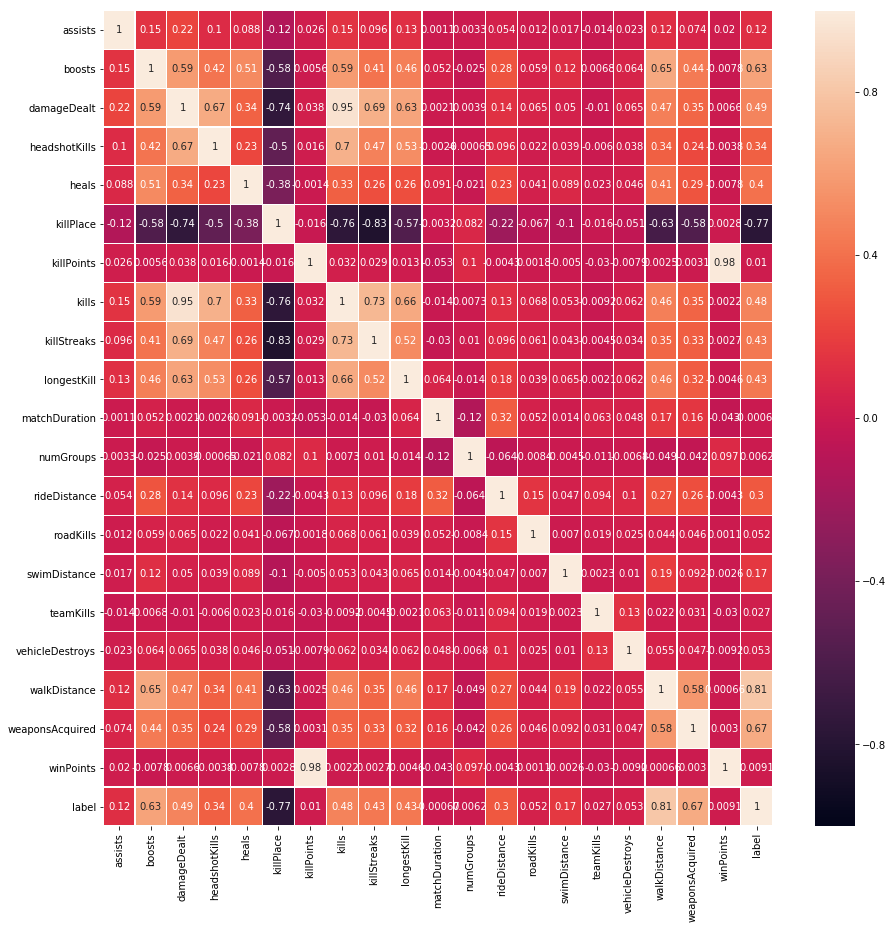

In [5]:
print_correlation_matrix(typology_data)

{0: 117553, 1: 106768, 2: 105774, 3: 101822, 4: 104844}
[117553, 106768, 105774, 101822, 104844]


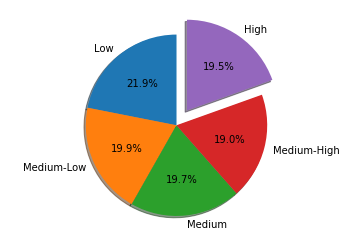

In [6]:
print_distribution(typology_data)

In [7]:
print("NUMBER OF ROW: ", len(typology_data))

NUMBER OF ROW:  536761


### Kills 

In [ ]:
avg_kill = statistics.mean(typology_data.kills)
print("{:<25}{:>5}".format("AVERAGE KILLS IN A MATCH:", round(avg_kill, 3)))

In [ ]:
print_kills_number(typology_data.kills)

### Walk

In [ ]:
print("{:<20}{:>6}".format("PLAYERS DIED IMMEDIATELY:",len(typology_data[typology_data.walkDistance == 0])))

In [ ]:
print_sns_hist(typology_data.walkDistance, "Walking Distance")

### Damage

In [ ]:
avg_damage = statistics.mean(typology_data.damageDealt)
print("{:<25}{:>5}".format("AVERAGE DAMAGE IN A MATCH: ", round(avg_damage, 3)))

In [ ]:
print_sns_hist(typology_data.damageDealt, "Damage inflicted")

### Walking x Damage

In [ ]:
print_sns_join_plot("walkDistance", "damageDealt", typology_data)

### Walking x Kills

In [ ]:
print_sns_join_plot("walkDistance", "kills", typology_data)

### Damage x Kills

In [ ]:
print_sns_join_plot("damageDealt", "kills", typology_data)

### Walking x Swimming

In [ ]:
print_sns_join_plot("walkDistance", "swimDistance", typology_data)

### Weapons pick up x Kills 

In [ ]:
print_sns_join_plot("weaponsAcquired", "kills", typology_data)

### Boosts x Kills 

In [ ]:
print_sns_join_plot("boosts", "kills", typology_data)

### High vs Low class study

<Figure size 4320x4320 with 0 Axes>

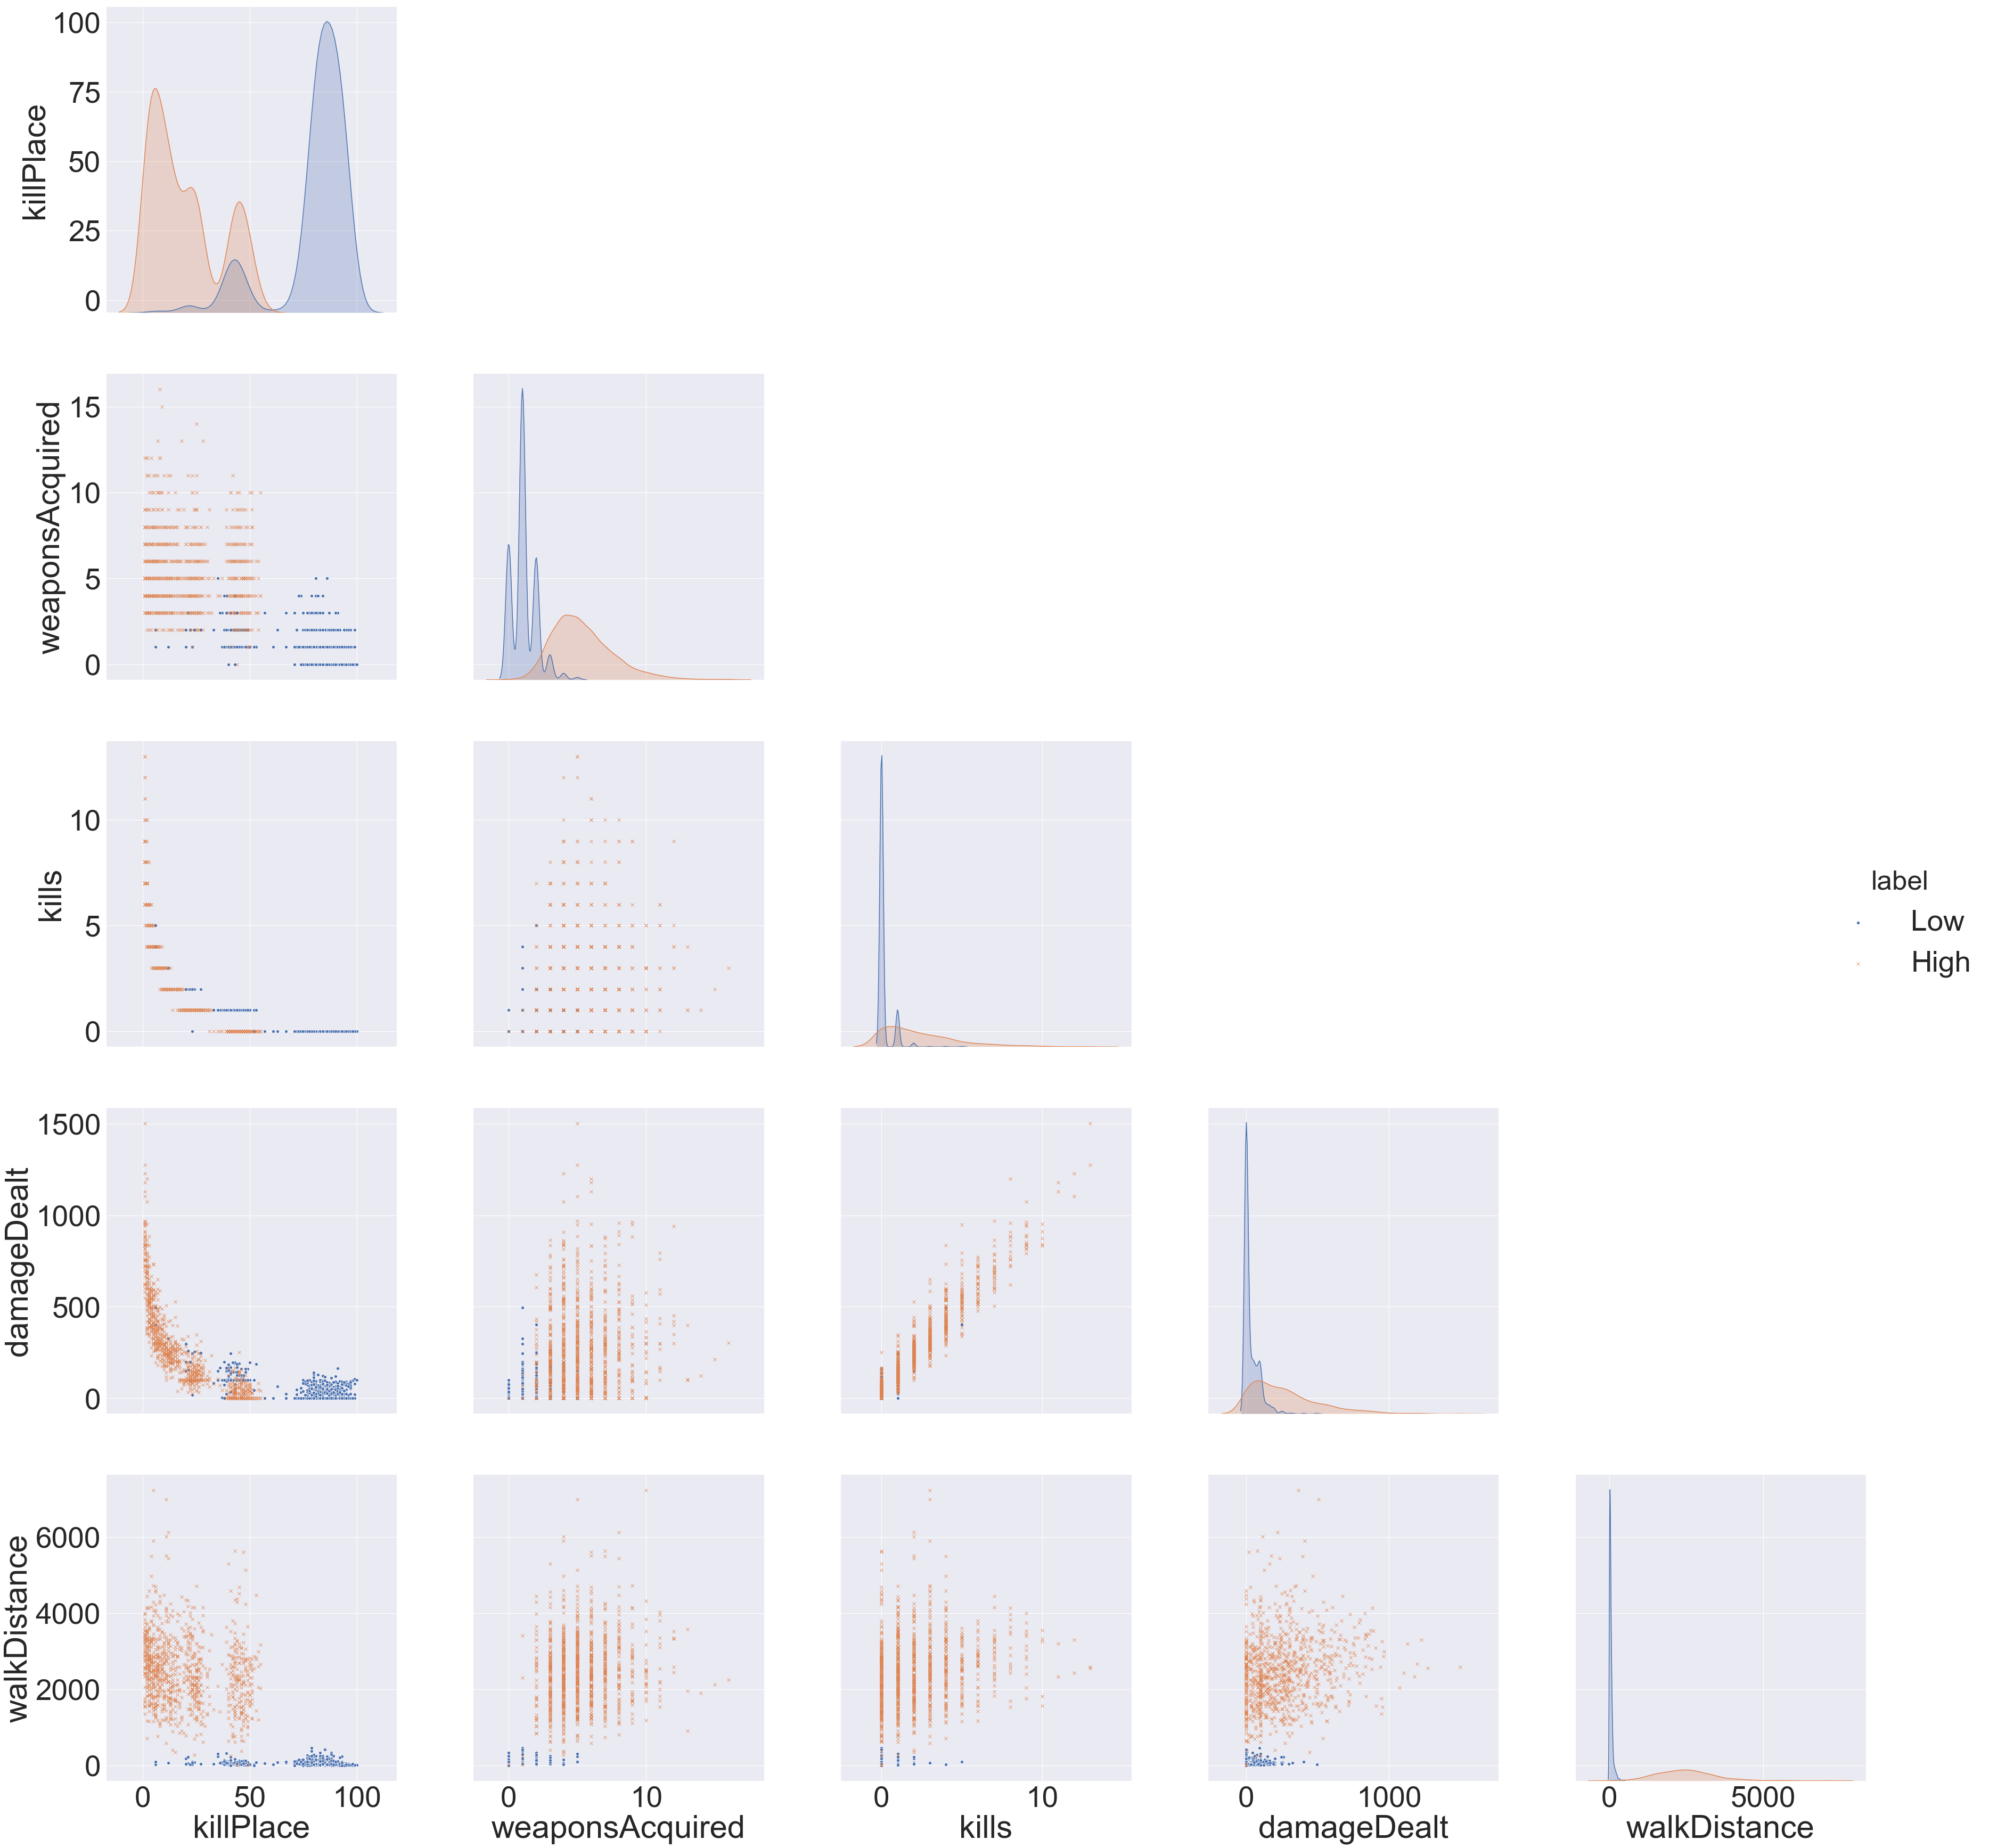

In [46]:
high = typology_data[typology_data.label == 4]
low = typology_data[typology_data.label == 0]
match_dataset = pd.concat([high[0:1000], low[0:1000]])
print_sns_pairplot(match_dataset, 'label')

In [ ]:
avg_kill = statistics.mean(high.kills)
print("{:<32}{:>5}".format("AVERAGE KILLS FOR PRO PLAYERS:", round(avg_kill, 3)))
print("{:<32}{:>5}".format("MAX KILLS BY PRO PLAYES:", max(high.kills)))
print("{:<32}{:>5}".format("MIN KILLS BY PRO PLAYES:", min(high.kills)))

In [ ]:
print_kills_number(high.kills)

In [ ]:
print_sns_hist(high.walkDistance, "Walking Distance")

In [ ]:
print_sns_hist(high.damageDealt, "Damage inflicted")

# Optimization

In [91]:
best_seen = list()
initialPoints = 10
iterations = 100
param = {'learning_rate': ('cont', [0.01,0.1]), 'momentum': ('cont', [0.1, 0.9]), 'first_layer': ('int', [1, 4]),
        'second_layer': ('int', [1, 2])}
sur_model = RandomForest()

In [92]:
param = {'conf_lr': ('cont', [0.01,0.1]), 'conf_mom': ('cont', [0.1, 0.9]), 'conf_rho': ('cont', [0.1, 0.95]),
         'conf_fl': ('int', [100, 300]), 'conf_sl': ('int', [50, 100]), 'conf_opt': ('int', [0, 3])}
sur_model = RandomForest()
acq = Acquisition(mode="ExpectedImprovement")

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.05853
TRY MOMENTUM:        0.40704
TRY FIRST LAYER:       188
TRY SECOND LAYER:       63

FOLDS NUMBER:            1


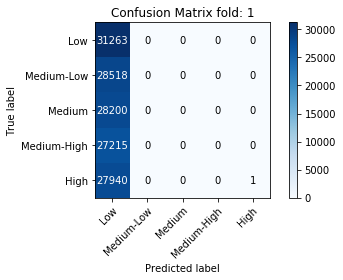

ACCURACY FOLD OBTAIN: 0.2184201180934906
FOLDS NUMBER:            2


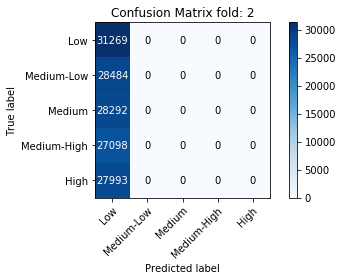

ACCURACY FOLD OBTAIN: 0.21845656633377075
FOLDS NUMBER:            3


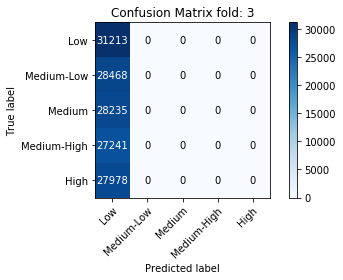

ACCURACY FOLD OBTAIN: 0.21806685626506805
ACCURACY OBTAIN:     0.2183145135641098


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [96]:
bo = GPGO(sur_model, acq, compute_accuracy, param, n_jobs=1)
bo._firstRun(1)

TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.03094
TRY MOMENTUM:        0.2089
TRY FIRST LAYER:       172
TRY SECOND LAYER:       77

FOLDS NUMBER:            1


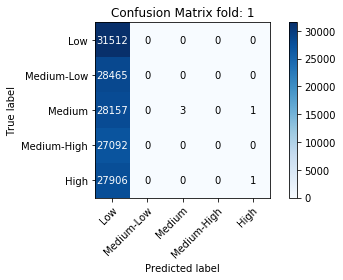

ACCURACY FOLD OBTAIN: 0.2201806604862213
FOLDS NUMBER:            2


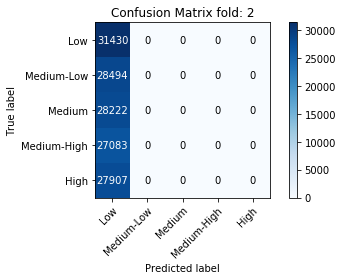

ACCURACY FOLD OBTAIN: 0.21958138048648834
FOLDS NUMBER:            3


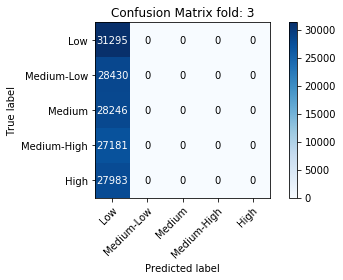

ACCURACY FOLD OBTAIN: 0.21863974630832672
ACCURACY OBTAIN:     0.21946726242701212
init   	 [3.09378676e-02 2.08902023e-01 4.23112094e-01 1.72000000e+02
 7.70000000e+01 0.00000000e+00]. 	  0.21946726242701212 	 0.21946726242701212


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.02856
TRY RHO:             0.59101
TRY FIRST LAYER:       212
TRY SECOND LAYER:       75

FOLDS NUMBER:            1


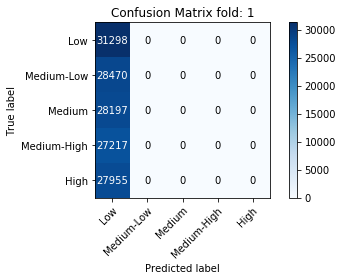

ACCURACY FOLD OBTAIN: 0.21865764260292053
FOLDS NUMBER:            2


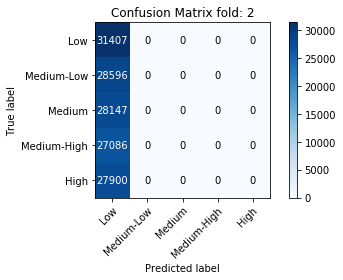

ACCURACY FOLD OBTAIN: 0.2194206863641739
FOLDS NUMBER:            3


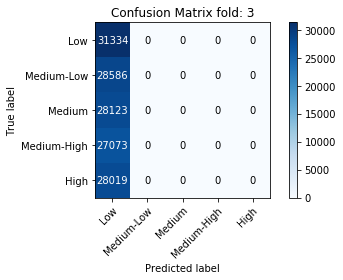

ACCURACY FOLD OBTAIN: 0.21891221404075623
ACCURACY OBTAIN:     0.21899684766928354
1      	 [2.85610267e-02 4.24964935e-01 5.91007826e-01 2.12000000e+02
 7.50000000e+01 1.00000000e+00]. 	  0.21899684766928354 	 0.21946726242701212


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.07132
TRY RHO:             0.78152
TRY FIRST LAYER:       241
TRY SECOND LAYER:       89

FOLDS NUMBER:            1


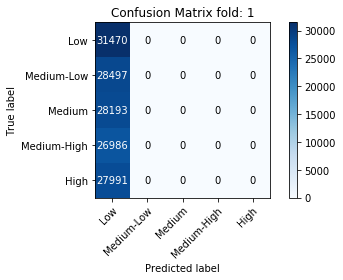

ACCURACY FOLD OBTAIN: 0.2198593020439148
FOLDS NUMBER:            2


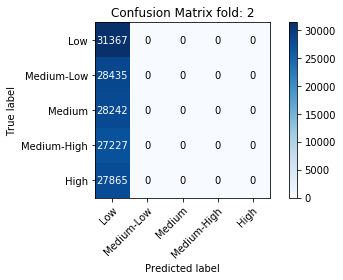

ACCURACY FOLD OBTAIN: 0.21914122998714447
FOLDS NUMBER:            3


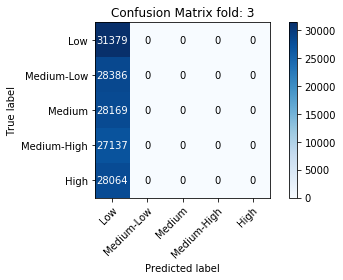

ACCURACY FOLD OBTAIN: 0.21922659873962402
ACCURACY OBTAIN:     0.21940904359022775
2      	 [7.13218074e-02 3.48633102e-01 7.81516515e-01 2.41000000e+02
 8.90000000e+01 1.00000000e+00]. 	  0.21940904359022775 	 0.21946726242701212


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.02487
TRY FIRST LAYER:       187
TRY SECOND LAYER:       78

FOLDS NUMBER:            1


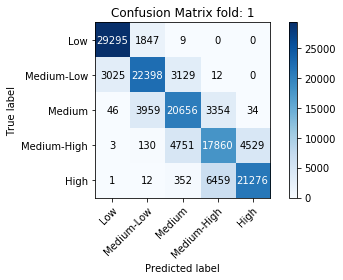

ACCURACY FOLD OBTAIN: 0.7788692116737366
FOLDS NUMBER:            2


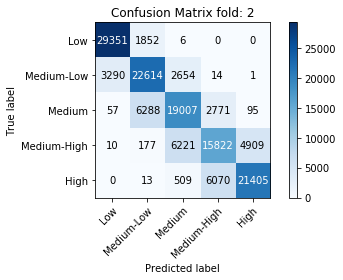

ACCURACY FOLD OBTAIN: 0.7559174299240112
FOLDS NUMBER:            3


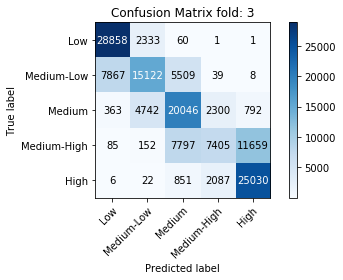

ACCURACY FOLD OBTAIN: 0.673916220664978
ACCURACY OBTAIN:     0.7362342874209086
3      	 [2.48698486e-02 7.29893175e-01 8.08618792e-01 1.87000000e+02
 7.80000000e+01 2.00000000e+00]. 	  0.7362342874209086 	 0.7362342874209086


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.03075
TRY MOMENTUM:        0.51654
TRY FIRST LAYER:       166
TRY SECOND LAYER:       79

FOLDS NUMBER:            1


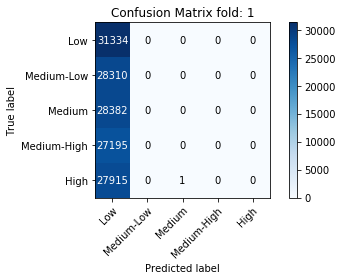

ACCURACY FOLD OBTAIN: 0.2189091593027115
FOLDS NUMBER:            2


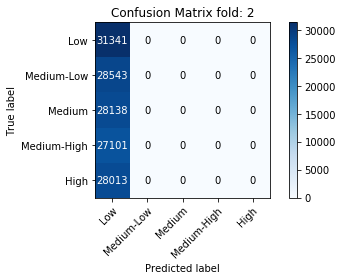

ACCURACY FOLD OBTAIN: 0.21895958483219147
FOLDS NUMBER:            3


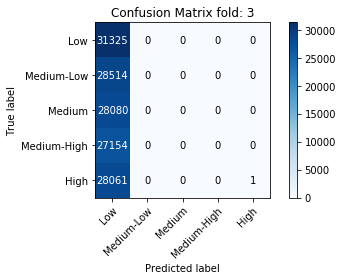

ACCURACY FOLD OBTAIN: 0.2188563197851181
ACCURACY OBTAIN:     0.21890835464000702
4      	 [3.07467603e-02 5.16539894e-01 9.35339329e-01 1.66000000e+02
 7.90000000e+01 0.00000000e+00]. 	  0.21890835464000702 	 0.7362342874209086


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.01021
TRY MOMENTUM:        0.65761
TRY FIRST LAYER:       208
TRY SECOND LAYER:       84

FOLDS NUMBER:            1


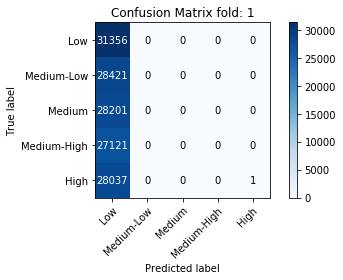

ACCURACY FOLD OBTAIN: 0.21906983852386475
FOLDS NUMBER:            2


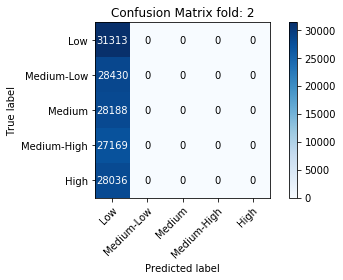

ACCURACY FOLD OBTAIN: 0.21876397728919983
FOLDS NUMBER:            3


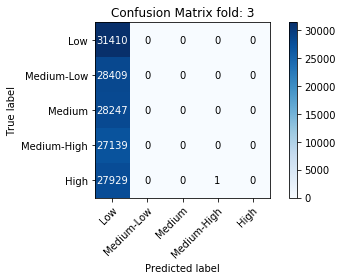

ACCURACY FOLD OBTAIN: 0.2194431871175766
ACCURACY OBTAIN:     0.21909233431021372
5      	 [1.02145658e-02 6.57608221e-01 8.49004916e-01 2.08000000e+02
 8.40000000e+01 0.00000000e+00]. 	  0.21909233431021372 	 0.7362342874209086


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05526
TRY FIRST LAYER:       206
TRY SECOND LAYER:       74

FOLDS NUMBER:            1


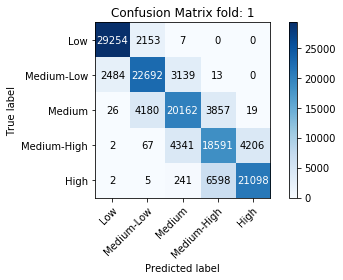

ACCURACY FOLD OBTAIN: 0.7810489535331726
FOLDS NUMBER:            2


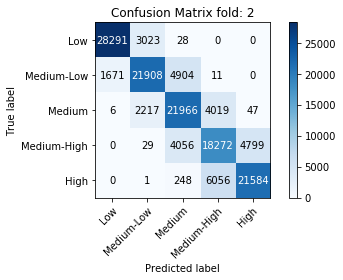

ACCURACY FOLD OBTAIN: 0.782619297504425
FOLDS NUMBER:            3


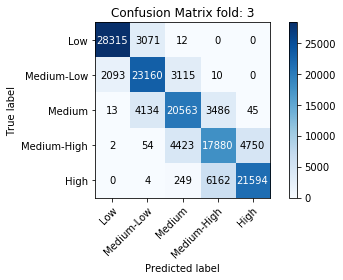

ACCURACY FOLD OBTAIN: 0.7790687084197998
ACCURACY OBTAIN:     0.7809123198191324
6      	 [5.52558911e-02 7.55918074e-01 8.48277582e-01 2.06000000e+02
 7.40000000e+01 2.00000000e+00]. 	  0.7809123198191324 	 0.7809123198191324


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.08321
TRY FIRST LAYER:       269
TRY SECOND LAYER:       72

FOLDS NUMBER:            1


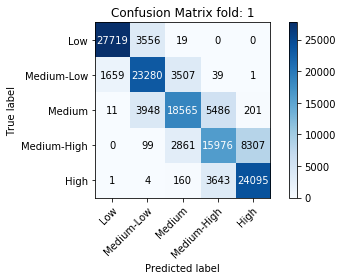

ACCURACY FOLD OBTAIN: 0.7659445405006409
FOLDS NUMBER:            2


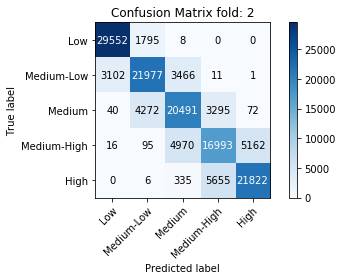

ACCURACY FOLD OBTAIN: 0.7743334770202637
FOLDS NUMBER:            3


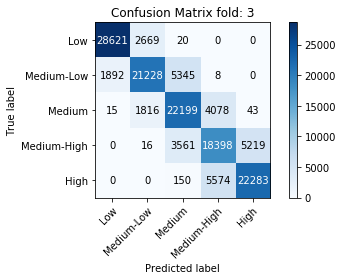

ACCURACY FOLD OBTAIN: 0.7875711917877197
ACCURACY OBTAIN:     0.7759497364362081
7      	 [8.32144973e-02 8.39866125e-01 2.27437755e-01 2.69000000e+02
 7.20000000e+01 2.00000000e+00]. 	  0.7759497364362081 	 0.7809123198191324


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.08276
TRY MOMENTUM:        0.85428
TRY FIRST LAYER:       191
TRY SECOND LAYER:       64

FOLDS NUMBER:            1


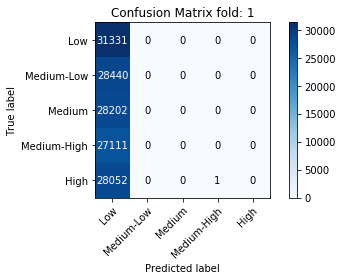

ACCURACY FOLD OBTAIN: 0.21888819336891174
FOLDS NUMBER:            2


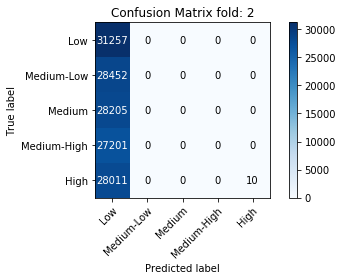

ACCURACY FOLD OBTAIN: 0.21844260394573212
FOLDS NUMBER:            3


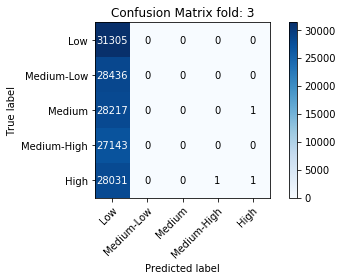

ACCURACY FOLD OBTAIN: 0.2187165915966034
ACCURACY OBTAIN:     0.21868246297041574
8      	 [8.27590807e-02 8.54283509e-01 5.82811999e-01 1.91000000e+02
 6.40000000e+01 0.00000000e+00]. 	  0.21868246297041574 	 0.7809123198191324


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.07787
TRY FIRST LAYER:       234
TRY SECOND LAYER:       64

FOLDS NUMBER:            1


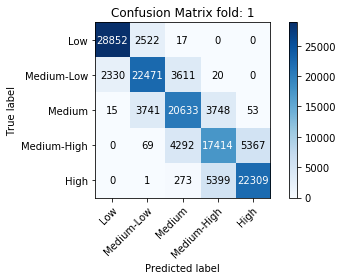

ACCURACY FOLD OBTAIN: 0.7802245616912842
FOLDS NUMBER:            2


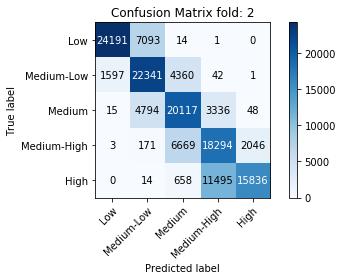

ACCURACY FOLD OBTAIN: 0.7040786147117615
FOLDS NUMBER:            3


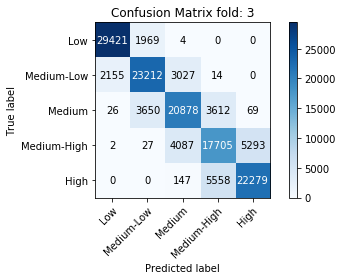

ACCURACY FOLD OBTAIN: 0.7929227948188782
ACCURACY OBTAIN:     0.7590753237406412
9      	 [7.78650397e-02 4.48196410e-01 4.70942318e-01 2.34000000e+02
 6.40000000e+01 2.00000000e+00]. 	  0.7590753237406412 	 0.7809123198191324


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09624
TRY FIRST LAYER:       108
TRY SECOND LAYER:       97

FOLDS NUMBER:            1


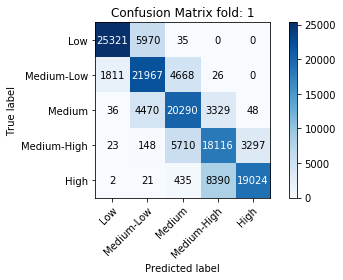

ACCURACY FOLD OBTAIN: 0.7315928339958191
FOLDS NUMBER:            2


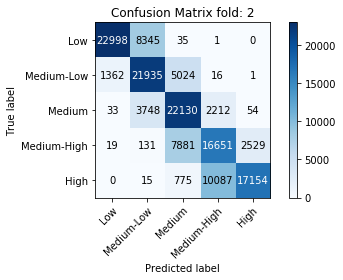

ACCURACY FOLD OBTAIN: 0.7047004103660583
FOLDS NUMBER:            3


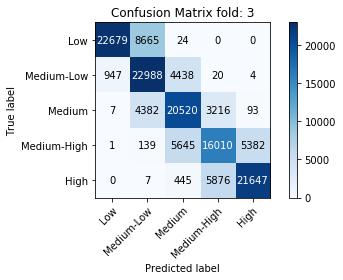

ACCURACY FOLD OBTAIN: 0.7254968881607056
ACCURACY OBTAIN:     0.720596710840861
10     	 [9.62417789e-02 1.70275787e-01 7.71040690e-01 1.08000000e+02
 9.70000000e+01 2.00000000e+00]. 	  0.720596710840861 	 0.7809123198191324


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [97]:
bo.run(max_iter=10, init_evals=1, resume=False)

# Performance Analysis

In [88]:
bo.best

array([6.72425044e-02, 4.51889797e-01, 9.44308202e-01, 2.36000000e+02,
       6.70000000e+01, 2.00000000e+00])